## Crawl all Wiki data starting from Bayer

In [1]:
!pip uninstall neuralcoref
!pip uninstall spacy
!pip install neuralcoref --no-binary neuralcoref
!pip install wikipedia-api
!pip install spacy==2.1.0


Uninstalling spacy-2.2.4:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.6/dist-packages/bin/*
    /usr/local/lib/python3.6/dist-packages/spacy-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/spacy/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/bin/theano_cache.py
    /usr/local/lib/python3.6/dist-packages/bin/theano_nose.py
Proceed (y/n)? y
  Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 378kB 3.5MB/s 
  Using cached https://files.pythonhosted.org/packages/10/b5/c7a92c7ce5d4b353b70b4b5b4385687206c8b230ddfe08746ab0fd310a3a/spacy-2.3.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/10/ae/ef3ae5e93639c0ef8e3eb32e3c18341e511b3c515fcfc603f4b808087651/thinc-7.4.1-cp36-cp36m-manylinux1_x86_64.whl
Skipping wheel build for neuralcoref, due to binaries being disabled for it.
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:


In [2]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
import concurrent.futures
from tqdm import tqdm
import wikipediaapi

def wiki_crawler(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist'.format(topic_name))
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Crawled', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Wikipedia pages scraped:', len(sources))
    return sources

In [4]:
bayer_data = wiki_crawler("Bayer")

Links Crawled: 100%|██████████| 553/553 [00:49<00:00, 11.18/s]

Wikipedia pages scraped: 513


In [5]:
bayer_data

,page,text,link,categories,topic
0,Bayer,Bayer AG (; German: [ˈbaɪɐ]) is a German multi...,https://en.wikipedia.org/wiki/Bayer,"[1863 establishments in Germany, Agriculture c...",Bayer
1,1991–92 Bayer 04 Leverkusen season,The 1991–92 Bayer 04 Leverkusen season was the...,https://en.wikipedia.org/wiki/1991%E2%80%9392_...,"[Articles with short description, Bayer 04 Lev...",Bayer
2,2000–01 Bayer 04 Leverkusen season,"Bayer Leverkusen had a solid season, where it ...",https://en.wikipedia.org/wiki/2000%E2%80%9301_...,"[All articles lacking sources, Articles lackin...",Bayer
3,2002–03 Bayer 04 Leverkusen season,"Bayer 04 Leverkusen had a shocking season, in ...",https://en.wikipedia.org/wiki/2002%E2%80%9303_...,"[Articles with short description, Bayer 04 Lev...",Bayer
4,2003–04 Bayer 04 Leverkusen season,Bayer 04 Leverkusen bounced back from the near...,https://en.wikipedia.org/wiki/2003%E2%80%9304_...,"[Articles with short description, Bayer 04 Lev...",Bayer
...,...,...,...,...,...
508,World War I,"World War I (often abbreviated as WWI or WW1),...",https://en.wikipedia.org/wiki/World_War_I,"[1910s in Serbia, All accuracy disputes, All a...",Bayer
509,Yasmin (drug),"Ethinylestradiol/drospirenone (EE/DRSP), sold ...",https://en.wikipedia.org/wiki/Ethinylestradiol...,"[All stub articles, Articles containing unveri...",Bayer
510,World War II,"World War II (WWII or WW2), also known as the ...",https://en.wikipedia.org/wiki/World_War_II,"[All articles with broken links to citations, ...",Bayer
511,Yisrael Gutman,Israel Gutman (Hebrew: ישראל גוטמן; 20 May 192...,https://en.wikipedia.org/wiki/Israel_Gutman,"[1923 births, 2013 deaths, Articles containing...",Bayer


In [6]:
B = bayer_data.loc[0,'text']
B[:len(B)//2]

'Bayer AG (; German: [ˈbaɪɐ]) is a German multinational pharmaceutical and life sciences company and one of the largest pharmaceutical companies in the world. Headquartered in Leverkusen, Bayer\'s areas of business include human and veterinary pharmaceuticals; consumer healthcare products; agricultural chemicals, seeds and biotechnology products. The company is a component of the Euro Stoxx 50 stock market index. Werner Baumann has been CEO since 2016.Founded in Barmen in 1863 as a dyestuffs factory, Bayer\'s first and best-known product was aspirin. In 1898 Bayer trademarked the name heroin for the drug diacetylmorphine and marketed it as a cough suppressant and non-addictive substitute for morphine until 1910. Bayer also introduced phenobarbital; prontosil, the first widely used antibiotic and the subject of the 1939 Nobel Prize in Medicine; the antibiotic Cipro (ciprofloxacin); and Yaz (drospirenone) birth control pills.\nIn 1925 Bayer was one of six chemical companies that merged t

In [7]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 826.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.1.0-cp36-none-any.whl size=828255078 sha256=043e668960a34ff558a273274ea6ae729dd5d4635b14c29984f83ff1168fe69c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hg5cjgi6/wheels/b4/d7/70/426d313a459f82ed5e06cc36a50e2bb2f0ec5cb31d8e0bdf09
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [8]:
!mkdir drug_data

## Extract Meds/Drug data from XML

In [9]:
import xml.etree.ElementTree as ET

In [10]:
import re
def to_dict(sent, index, type_g):
  s = len(type_g)
  tupl = (sent,)
  result = {}
  result['entities'] = []

  for i in range(s):
    if ';' in index[i]:
      index[i]=index[i].split(';')[0]
    begin = index[i].split('-')[0]
    end = index[i].split('-')[1]
    label = '%s' %type_g[i].upper()
    result['entities'].append((int(begin), int(end)+1, label))
  tupl+=(result,)
  return tupl

In [11]:
def xml_to_json(fin, result = []):
  tree = ET.parse(fin)
  root = tree.getroot()
  for neighbor in root.iter('sentence'):
    #print(neighbor.attrib.get('text'))
    text = neighbor.attrib.get('text')
    index = []
    tags = []
    values = []
    for each in neighbor:
      if each.tag == 'entity':
        index.append(each.attrib.get('charOffset'))
        tags.append(each.attrib.get('type'))
        #print(each.attrib.get('charOffset'), each.attrib.get('type'))
    result.append(to_dict(text, index, tags))
  return result
    

In [14]:
import glob
for file in glob.glob('drug_data/*.xml'):
  d = xml_to_json(file)
print(len(d))

5675


In [40]:
import spacy
import random
#import en_trf_bertbaseuncased_lg
import en_core_web_lg
from spacy.util import minibatch

x = [('Germany is one of the best countries in Europe',
  {'entities': [(0, 7, 'GPE'), (40, 46, 'LOC')]}),
 ('Bayer is a pharmaceutical company',
  {'entities': [(0, 5, 'ORG')]}),
 ('Werner Baumann has been CEO of Bayer since 2016',
  {'entities': [(0, 14, 'PERSON'), (31, 36, 'ORG'), (43, 47, 'DATE')]}),
 ('Monsanto has been aquired by Bayer',
  {'entities': [(0, 8, 'ORG'), (29, 34, 'ORG')]}),
  ('It used Aspirin widely',
  {'entities': [(8, 15, 'BRAND')]})]

def train_spacy(data,iterations):
    TRAIN_DATA = d
    nlp = en_core_web_lg.load()  
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       
    else:
        ner = nlp.get_pipe('ner')

    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for i in range(iterations):
          random.shuffle(TRAIN_DATA)
          TRAIN_DATA+=x 
          losses = {}
          for batch in minibatch(TRAIN_DATA[:10], size=2):
              texts, lbls = zip(*batch)
              nlp.update(texts, lbls, sgd=optimizer, losses=losses)
          print(i, losses)
    return nlp



# Save our trained Model
#modelfile = input("Enter your Model Name: ")
#prdnlp.to_disk(modelfile)


#Test your text
# test_text = input("Enter your testing text: ")
# doc = prdnlp(test_text)
# for ent in doc.ents:
#     print(ent.label_, ent.text)

## Constructing knowledge graph

In [12]:
#Filter a sequence of Span objects and remove duplicates or overlaps. 
#Useful for creating named entities (where one token can only be part of one entity)
#When spans overlap, the (first) longest span is preferred over shorter spans.
def filter_spans(spans):
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result

In [ ]:
import neuralcoref
import regex as re
import en_core_web_lg
#nlp = spacy.load('en_core_web_lg')
nlp = en_core_web_lg.load()
#nlp = train_spacy(d, 10)
neuralcoref.add_to_pipe(nlp)

In [21]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 11.1MB 1.2MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp36-none-any.whl size=11074435 sha256=5102308b084ae6a69374c6fed40b2dbf187a47025fd13a9e02c701bc4a11947b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qidqmf64/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [26]:
import spacy
from spacy import displacy
text = """Founded in Barmen in 1863 as a dyestuffs factory, Bayer's first and best-known product was aspirin. In 1898 Bayer trademarked the name heroin for the drug diacetylmorphine and marketed it as a cough suppressant and non-addictive substitute for morphine until 1910. Bayer also introduced phenobarbital; prontosil, the first widely used antibiotic and the subject of the 1939 Nobel Prize in Medicine; the antibiotic Cipro (ciprofloxacin); and Yaz (drospirenone) birth control pills."""
doc = nlp(text)
sentence_spans = list(doc.sents)
displacy.render(sentence_spans, style="dep", jupyter=True)

In [13]:


def triplets_extraction(text, coref=True):
    #preprocessing text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        #print(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Triplets extracted:', str(len(filtered_ent_pairs)))
    return pairs
    #print(len(ent_pairs))


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type

100%|██████████| 40155833/40155833 [00:00<00:00, 53347138.22B/s]


In [27]:
B=bayer_data.loc[0,'text']
#A = B[:len(B)//4]
triplets_extraction(B)

Triplets extracted: 42


,subject,relation,object,subject_type,object_type
0,Bayer's areas,include,human veterinary pharmaceuticals,ORG,NOUN_CHUNK
1,Bayer,introduced,phenobarbital,ORG,NOUN_CHUNK
2,Bayer CropScience,develops,genetically modified crops,ORG,NOUN_CHUNK
3,Aspirin,lost,Bayer's trademark,NOUN_CHUNK,ORG
4,sources,support,conflicting claims,NOUN_CHUNK,NOUN_CHUNK
5,mainstream historians,attribute,invention,NOUN_CHUNK,NOUN_CHUNK
6,Bayer,licensed,patent,ORG,NOUN_CHUNK
7,Bayer scientists,discovered,suramin,ORG,NOUN_CHUNK
8,discovery,opened,new era,NOUN_CHUNK,NOUN_CHUNK
9,Domagk,won,the Nobel Prize in Physiology or Medicine,ORG,WORK_OF_ART


In [28]:
triplets = triplets_extraction(bayer_data.loc[0,'text'])

Triplets extracted: 42


In [29]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_graph(pairs, i):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(40, 30), dpi=70)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=23,
        linewidths=2,
        pos=layout
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels)
    plt.figtext(.5,.9,bayer_data.loc[i,'page'], fontsize=50, ha='center')
    plt.axis('off')
    plt.show()

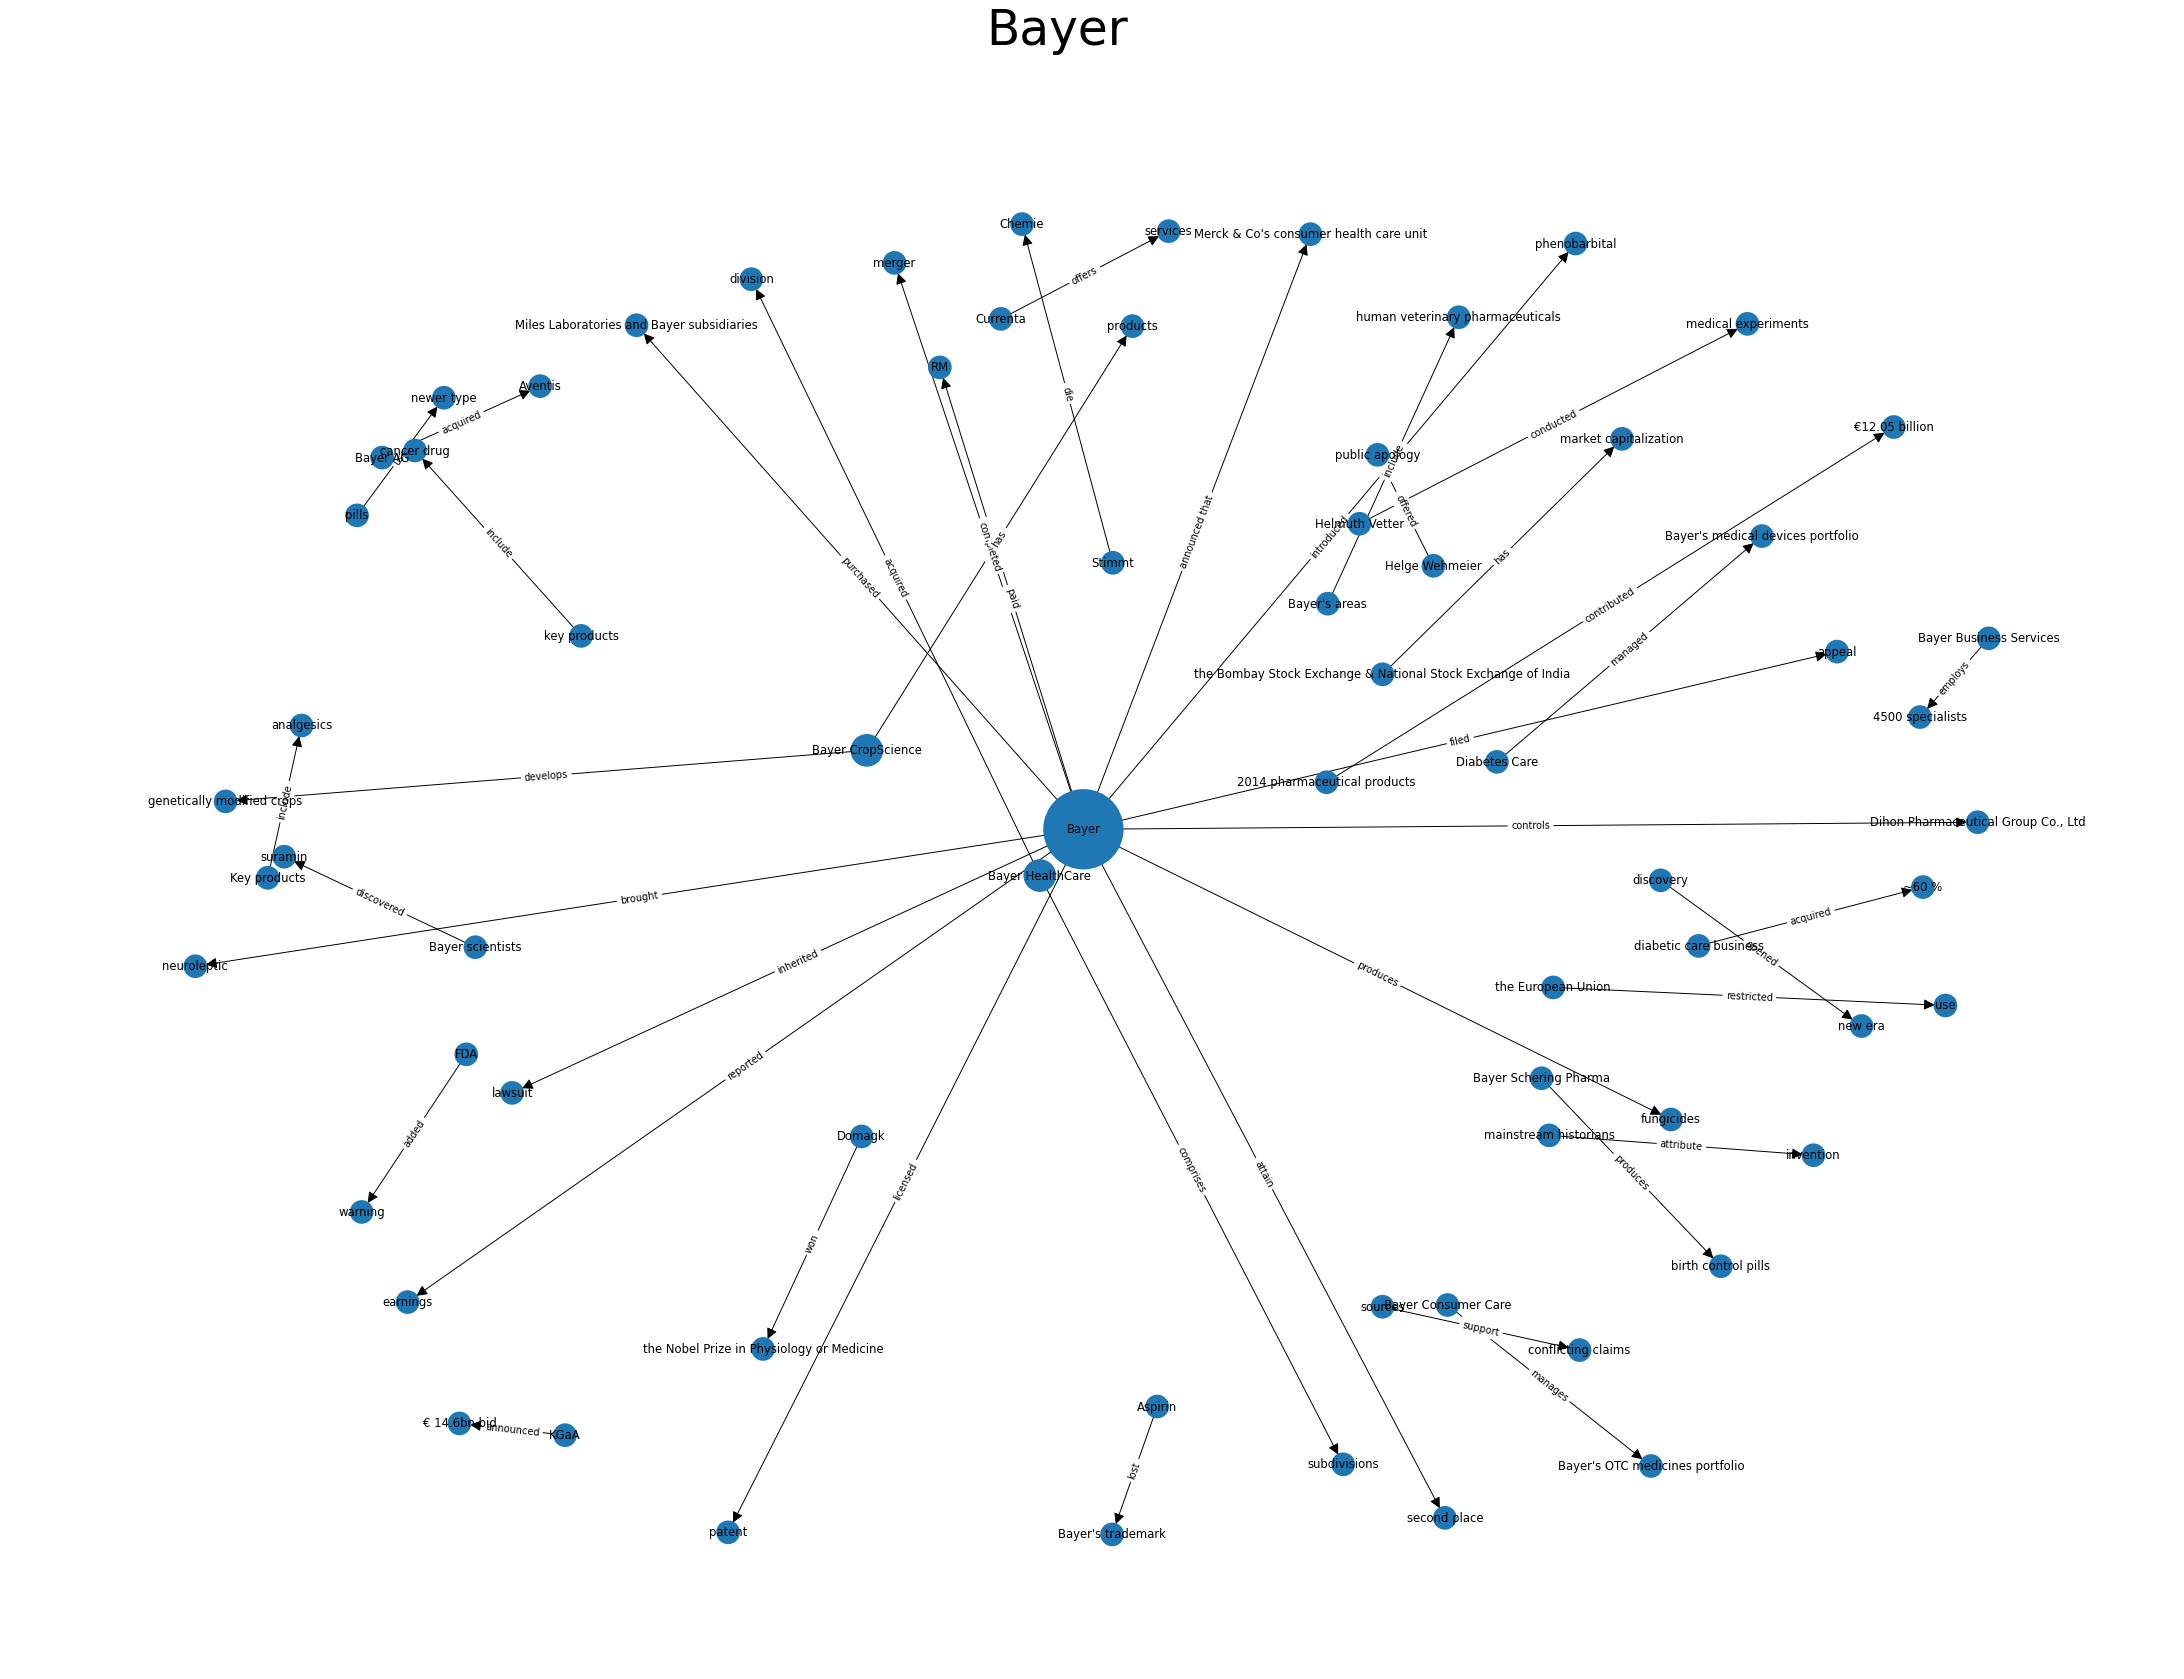

In [30]:
draw_graph(triplets, 0)

In [ ]:
#!cat /var/log/colab-jupyter.log

In [106]:
filter_keywords = ["drug","chemical","pharmacy", "pharmaceutical", "biology", \
                   "biotechnology", "contraceptive", "disorder", "sick"\
                   "illness", "treat", "chemist", "biologist"\
                   "doctor", "pharmacist", "scientist", "agriculture", "antibiotic"]

In [107]:
filtered_bayer_data = bayer_data[bayer_data['text'].str.contains('|'.join(filter_keywords))]
filtered_bayer_data

,page,text,link,categories,topic
0,Bayer,Bayer AG (; German: [ˈbaɪɐ]) is a German multi...,https://en.wikipedia.org/wiki/Bayer,"[1863 establishments in Germany, Agriculture c...",Bayer
20,AB InBev,"Anheuser-Busch InBev SA/NV, commonly known as ...",https://en.wikipedia.org/wiki/AB_InBev,"[2008 establishments in Belgium, Anheuser-Busc...",Bayer
22,Acetylsalicylic acid,"Aspirin, also known as acetylsalicylic acid (A...",https://en.wikipedia.org/wiki/Aspirin,"[1897 in Germany, 1897 in science, Acetate est...",Bayer
23,Adidas,Adidas AG (German: [ˈʔadiˌdas] AH-dee-DAHS; st...,https://en.wikipedia.org/wiki/Adidas,"[1970s fashion, 1980s fashion, 1989 mergers an...",Bayer
24,Adverse effect,An adverse effect is an undesired harmful effe...,https://en.wikipedia.org/wiki/Adverse_effect,"[All articles needing additional references, A...",Bayer
...,...,...,...,...,...
507,Xofigo,"Radium-223 (223Ra, Ra-223) was discovered in ...",https://en.wikipedia.org/wiki/Radium-223,"[All articles with incomplete citations, All a...",Bayer
508,World War I,"World War I (often abbreviated as WWI or WW1),...",https://en.wikipedia.org/wiki/World_War_I,"[1910s in Serbia, All accuracy disputes, All a...",Bayer
509,Yasmin (drug),"Ethinylestradiol/drospirenone (EE/DRSP), sold ...",https://en.wikipedia.org/wiki/Ethinylestradiol...,"[All stub articles, Articles containing unveri...",Bayer
511,Zyklon B,Zyklon B (German: [tsyˈkloːn ˈbeː] (listen); t...,https://en.wikipedia.org/wiki/Zyklon_B,"[Articles containing French-language text, Art...",Bayer


In [110]:
triplets = triplets_extraction(bayer_data.loc[22,'text'])

Triplets extracted: 35


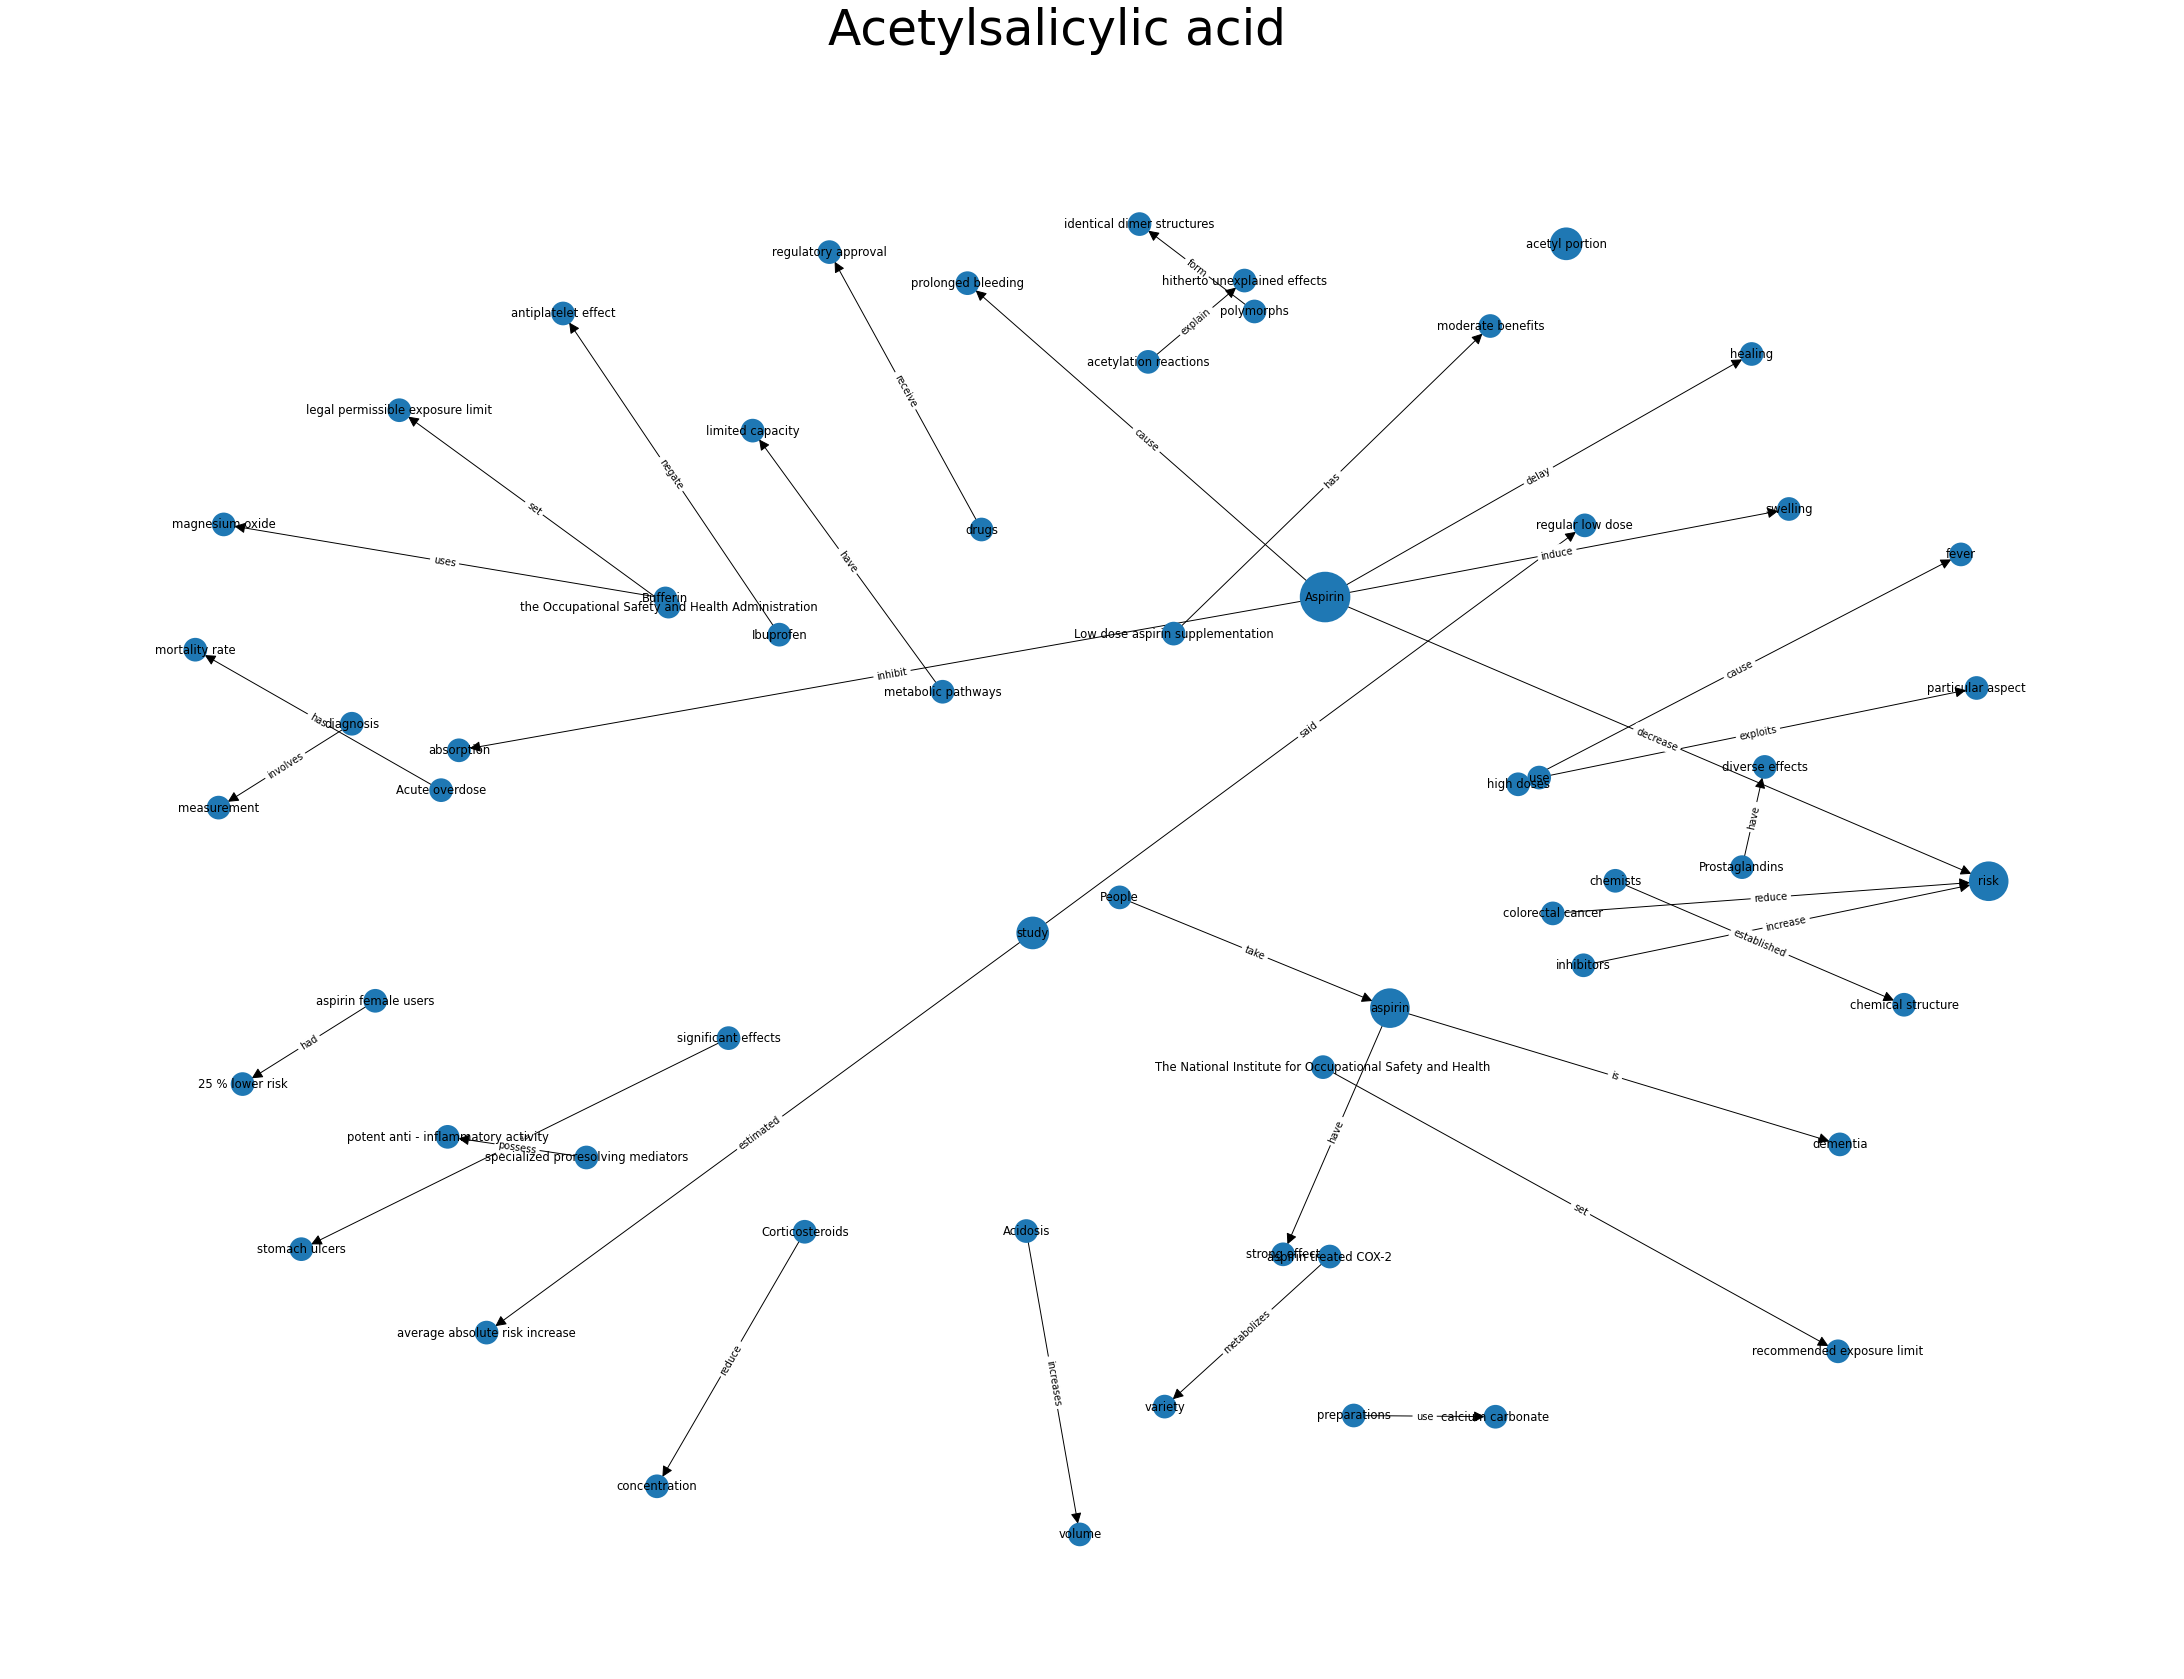

In [111]:
draw_graph(triplets, 22)

In [112]:
triplets = triplets_extraction(bayer_data.loc[338,'text'])

Triplets extracted: 54


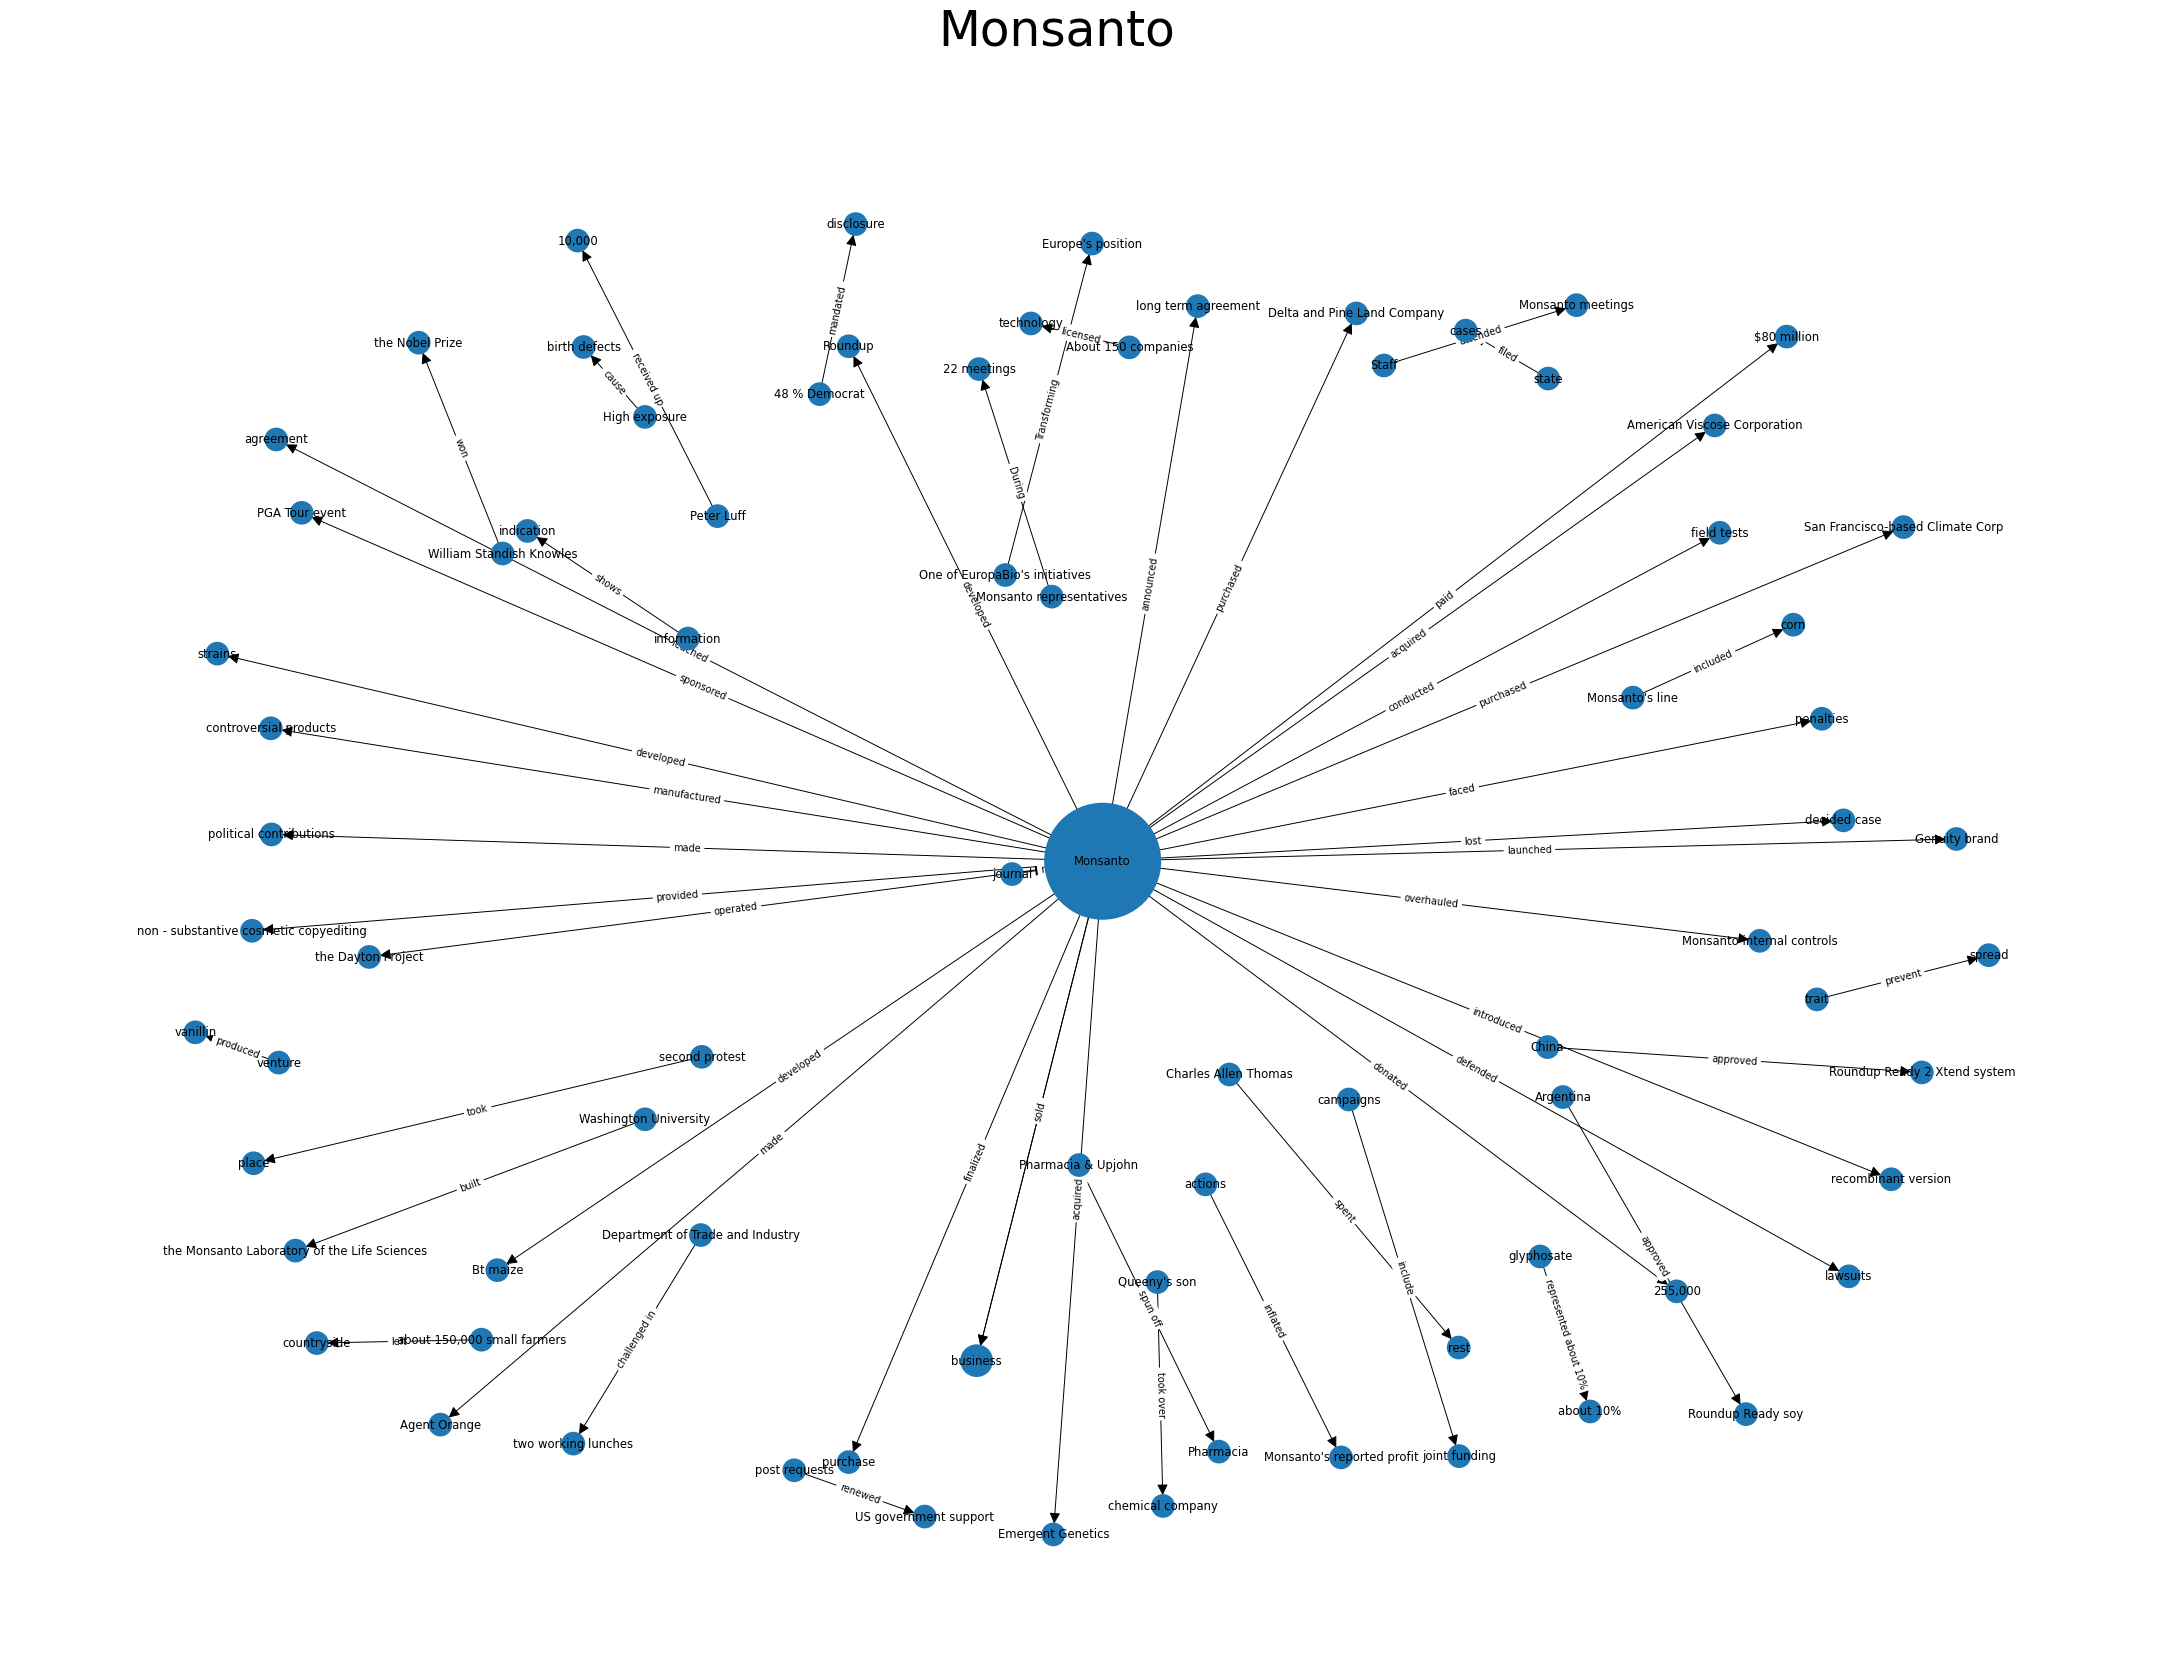

In [113]:
draw_graph(triplets, 338)

In [114]:
triplets = triplets_extraction(bayer_data.loc[339,'text'])

Triplets extracted: 32


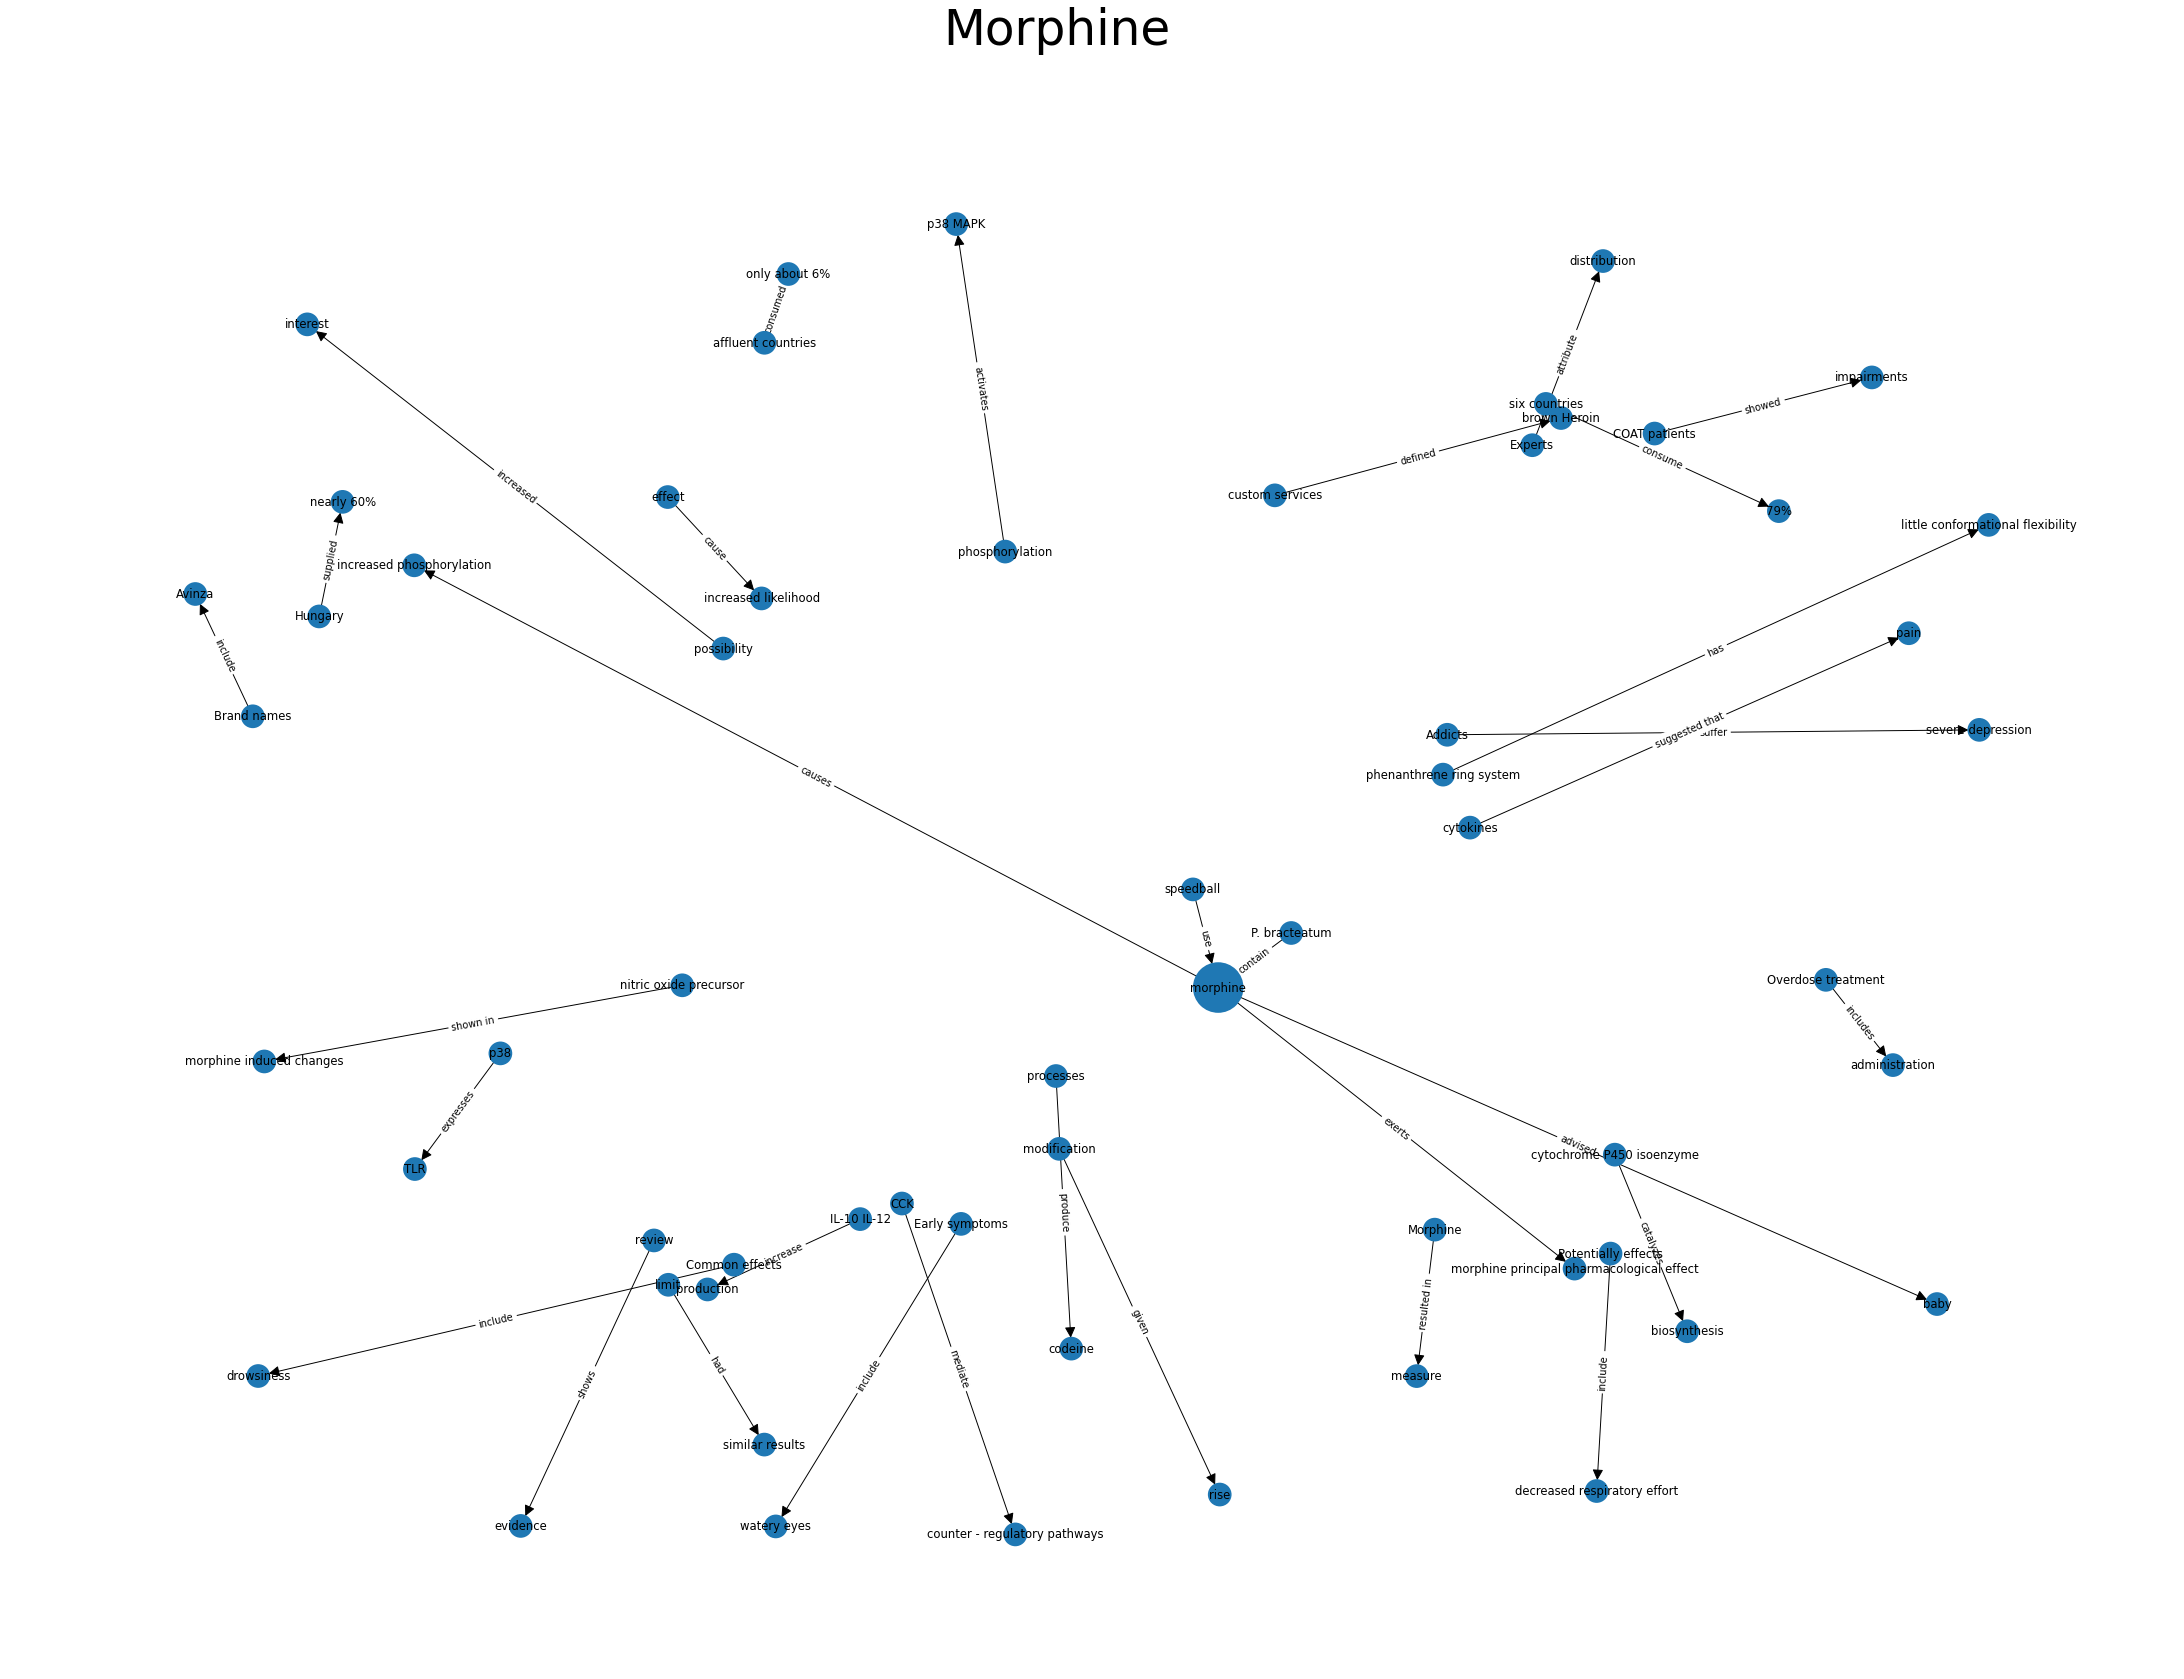

In [115]:
draw_graph(triplets, 339)

In [56]:
bayer_data.to_excel('out.xlsx')